# RL coursework, part IV (30 pts in total)

---

**Name:** Yuan Lu

**SN:** 20114649

---

**Due date:** *April 10th, 2025*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [141]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

## Section A: Multi-step + offpolicy in practice [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [142]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [143]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with full importance-sampling corrections, so that
    the return G_t is corrected with the full importance-sampling correction of
    the rest of the trajectory.
    """
    T = len(rewards)
    R = rewards
    gamma = discounts
    lam = trace_parameter

    # Compute state-value estimates for s_0, s_1, ..., s_T.
    V = np.array([v_fn(s) for s in observations])
    G = np.zeros(T)

    # Compute full importance-sampling ratios.

    # rho = np.flip(np.cumprod(pi/mu)) (this is consistent with the notation on the slides but
    # because of this:
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    # we need to do this to correct:
    # For each t, we want ρ_t = (π_{t+1}/μ_{t+1}) * (π_{t+2}/μ_{t+2}) * ... * (π_{T-1}/μ_{T-1})
    rho = np.ones(T)
    # Compute the product from time t+1 to T-1.
    rho[:-1] = np.flip(np.cumprod(np.flip(pi[1:] / mu[1:])))

    # Backward recursion for the multi-step return.
    for t in reversed(range(T)):
        if t == T - 1:
            # At the last step: G_{T-1} = R_T + γ_T V(s_T)
            G[t] = R[t] + gamma[t] * V[t+1]
        else:
            # For earlier steps: G_t = R_{t+1} + γ_{t+1}[(1-λ)V(s_{t+1}) + λ G_{t+1}]
            G[t] = R[t] + gamma[t] * ((1 - lam) * V[t+1] + lam * G[t+1])

    # Combine the immediate bootstrapping with the multi-step update corrected by ρ_t.
    # For each t: Return_t = (1 - λ) V(s_t) + λ G_t * ρ_t.
    return (1 - lam) * V[:-1] + lam * (G * rho)

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with per-decision importance-sampling corrections.
    """
    T = len(rewards)
    R = rewards
    gamma = discounts
    lam = trace_parameter

    # Compute state-value estimates for s_0,..., s_T.
    V = np.array([v_fn(s) for s in observations])
    G = np.zeros(T)

    # Compute one-step importance-sampling ratios.
    rho = pi / mu

    # Backward recursion.
    for t in reversed(range(T)):
        if t == T - 1:
            # At the final step: G_{T-1} = ρ_{T-1} [ R_T + γ_T V(s_T) ]
            G[t] = rho[t] * (R[t] + gamma[t] * V[t+1])
        else:
            # For t < T-1: G_t = ρ_t [ R_{t+1} + γ_{t+1} ((1 - λ) V(s_{t+1}) + λ G_{t+1}) ]
            G[t] = rho[t] * (R[t] + gamma[t] * ((1 - lam) * V[t+1] + lam * G[t+1]))

    # Return the combined immediate bootstrapping with the multi-step update.
    return (1 - lam) * V[:-1] + lam * G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with
    1. per-decision importance-sampling corrections, and
    2. control variates
    """
    T = len(rewards)
    R = rewards
    gamma = discounts
    lam = trace_parameter

    # Evaluate state values for s_0,..., s_T.
    V = np.array([v_fn(s) for s in observations])
    G = np.zeros(T)

    # Compute one-step importance-sampling ratios.
    rho = pi / mu

    # Backward recursion with control variates.
    for t in reversed(range(T)):
        if t == T - 1:
            # At the final time step:
            # G_{T-1} = ρ_{T-1}[R_T + γ_T V(s_T)] + (1 - ρ_{T-1}) V(s_{T-1})
            G[t] = rho[t]*(R[t] + gamma[t]*V[t+1]) + (1 - rho[t])*V[t]
        else:
            # For earlier steps:
            # G_t = ρ_t[ R_{t+1} + γ_{t+1} ((1 - λ) V(s_{t+1}) + λ G_{t+1}) ] + (1 - ρ_t) V(s_t)
            G[t] = rho[t]*(R[t] + gamma[t]*((1 - lam)*V[t+1] + lam*G[t+1])) + (1 - rho[t])*V[t]

    return (1 - lam)*V[:-1] + lam*G


def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with
    1. per-decision importance-sampling corrections, and
    2. control variates, and
    3. adaptive bootstrapping.

    Implement the adaptive bootstrapping with an *additional* trace parameter
    lambda, such that lambda_t = lambda * min(1, 1/rho_t).
    """
    T = len(rewards)
    R = rewards
    gamma = discounts
    lam = trace_parameter

    # Compute state-value estimates for s_0,..., s_T.
    V = np.array([v_fn(s) for s in observations])
    G = np.zeros(T)

    # Compute one-step importance-sampling ratios.
    rho = pi / mu

    # Compute the adaptive bootstrapping parameter for each time step:
    # λ_t = λ * min(1, 1/ρ_t)
    # This caps the effective bootstrapping when ρ_t is high.
    lambda_t = lam * np.minimum(1.0, 1.0 / rho)

    # Backward recursion with adaptive bootstrapping.
    for t in reversed(range(T)):
        if t == T - 1:
            # At the final step:
            # G_{T-1} = λ_{T-1}ρ_{T-1} [ R_T + γ_T V(s_T) ] + (1 - λ_{T-1}ρ_{T-1}) V(s_{T-1})
            G[t] = lambda_t[t]*rho[t]*(R[t] + gamma[t]*V[t+1]) + (1 - lambda_t[t]*rho[t])*V[t]
        else:
            # For t < T-1:
            # G_t = λ_tρ_t [ R_{t+1} + γ_{t+1} ((1 - λ) V(s_{t+1}) + λ G_{t+1}) ]
            #       + (1 - λ_tρ_t) V(s_t)
            G[t] = lambda_t[t]*rho[t]*(R[t] + gamma[t]*((1 - lam)*V[t+1] + lam*G[t+1])) + (1 - lambda_t[t]*rho[t])*V[t]

    return (1 - lam)*V[:-1] + lam*G

In [144]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 21.147 261.844 194.432   5.373   0.65 ]


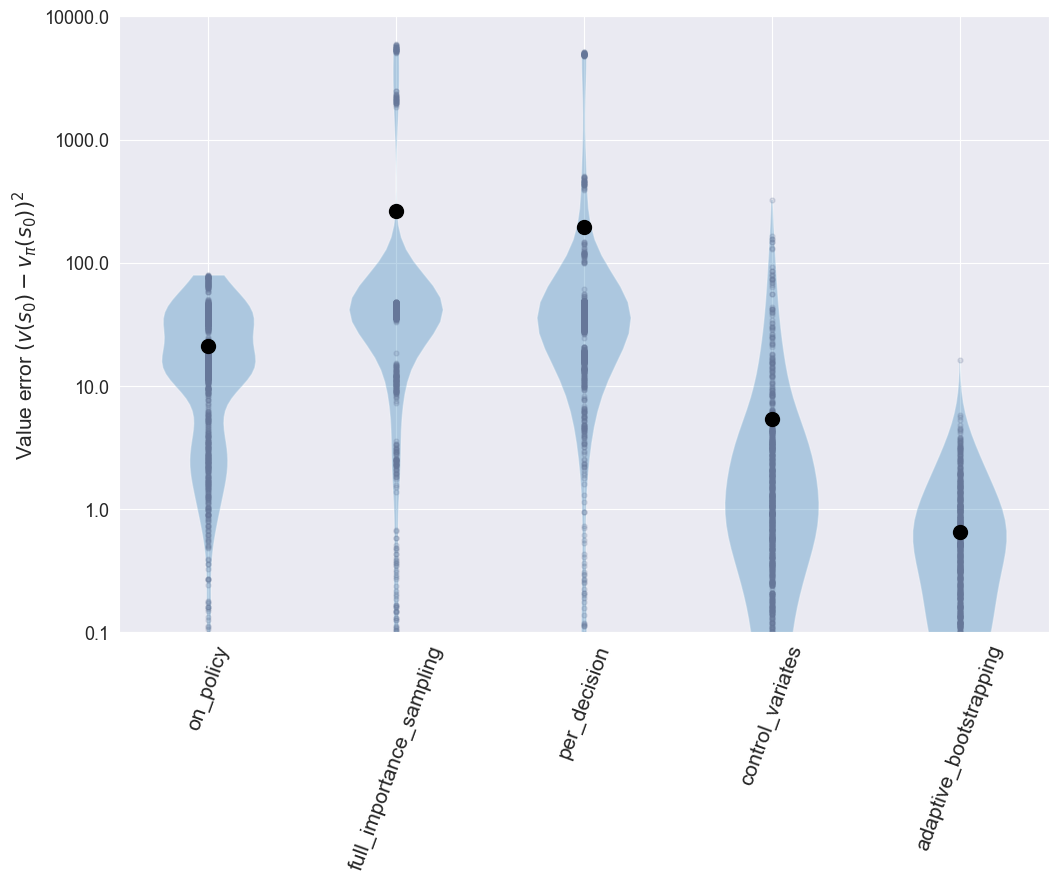

In [145]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.


The different return estimators rank in terms of value error primarily because of the tradeoff between bias and variance in off-policy corrections:

- **Full Importance Sampling:**
  This method reweights the entire future trajectory by the product of importance sampling ratios. When the behavior and target policies differ substantially, these products can become extremely large or small, which leads to very high variance. The high variance results in large mean squared errors (MSE) in value estimation. Consequently, full importance sampling tends to perform the worst in terms of value error.

- **Per-decision Importance Sampling:**
  Instead of reweighting the full trajectory, this approach applies importance sampling corrections at each individual step. This “per-step” correction reduces the compounding effect of the ratios, thereby lowering the overall variance compared to full importance sampling. Although it still suffers from high variance when some individual ratios are extreme, its performance is generally better than full importance sampling.

- **On-Policy Estimation:**
  On-policy methods use the same policy for both data collection and evaluation. As a result, no importance sampling correction is necessary, which eliminates the variance induced by reweighting. However, on-policy methods can be limited by exploration or bootstrapping bias if the value estimates are not very accurate. Overall, on-policy performance is typically better than the high-variance off-policy methods, but may still be outperformed by advanced variance reduction techniques.

- **Control Variates:**
  This method enhances per-decision importance sampling by adding a control variate term (typically of the form $(1-\rho_t)v(s_t)$) that helps cancel out some of the variance caused by the importance sampling ratios. This variance reduction leads to lower MSE compared to both full and per-decision importance sampling, making it a more effective off-policy estimator.

- **Adaptive Bootstrapping:**
  Adaptive bootstrapping further improves the estimator by dynamically adjusting the bootstrapping factor based on the magnitude of the importance sampling ratios (e.g., capping the effective $\lambda$ when $\rho_t$ is large). This adaptive adjustment prevents overly aggressive corrections for rare events, thereby reducing variance even more. In practice, this cumulative benefit makes adaptive bootstrapping the best performing off-policy method in terms of value error.




### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

Yes. While the best return estimate (e.g. adaptive bootstrapping) minimizes the value error in these experiments, we might not always choose it in off-policy learning for:

- **The Deadly Triad:**
  When combining off-policy learning with function approximation and bootstrapping, one risks encountering the deadly triad. Adaptive bootstrapping adjusts the bootstrapping factor based on importance sampling ratios, which can sometimes lead to over-bootstrapping when there are many rare behavior–target action combinations. This over-bootstrapping can increase instability or even cause divergence when using function approximation.

- **Bias–Variance Tradeoff and Robustness:**
  Although adaptive bootstrapping reduces variance and thus improves value error in controlled experiments, it introduces bias. In some environments or with certain function approximators, this bias might hurt performance more than the high variance of simpler methods. In other words, a method with slightly higher variance but less bias might yield better overall performance in practice.

- **Simplicity and Computational Efficiency:**
  In some cases, the environment may be simple or trajectories short, so the benefits of complex variance reduction techniques may not justify the additional computational cost or implementation complexity. A simpler method (e.g., per-decision importance sampling without the extra control variate and adaptive adjustments) might perform nearly as well while being more robust or easier to implement.

- **Similarity of Behavior and Target Policies:**
  When the behavior policy is close to the target policy, the importance sampling ratios are near one. In this case, the benefits of adaptive bootstrapping and control variates are minimal, and the extra corrections might even introduce unnecessary complexity or bias compared to a simpler approach.



## Section B: Potential different algorithms/updates [19 points total]
 Consider a MDP $M = (\mathbb{S}, \mathbb{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

#### (i) Convergence of the Tabular Update

We consider the TD error:
$$
\delta_t = R(S_t, A_t) + \gamma\, R(S_{t+1}, A_{t+1}) + \gamma^2\, \max_{a} q(S_{t+2}, a) - q(S_t, A_t)
$$
and a corresponding tabular update:
$$
q(S_t, A_t) \leftarrow q(S_t, A_t) + \alpha_t\, \delta_t \,,
$$
with step-sizes $\{\alpha_t\}$ satisfying the Robbins–Monro conditions.

**Defining the Operator:**

For any state–action pair $(s,a)$, define an operator $T$ acting on the action-value function $q$ as:
$$
Tq(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma\, R(S',A') + \gamma^2\, \max_{a'} q(S'', a') \,\Big|\, s,a\Bigr]
$$
where:
- $S'$ is the next state drawn from $p(\cdot \mid s,a)$,
- $A'$ is the action taken in $S'$ according to the fixed behavior policy $\mu$, and
- $S''$ is the state reached after taking action $A'$ (i.e. $S''\sim p(\cdot\mid S',A')$).

**Contraction Property:**

Notice that the only term involving $q$ on the right-hand side is $\gamma^2\, \max_{a'} q(S'', a')$. The max-operator is Lipschitz with constant 1 (i.e. for any $q,q'$, we have
$$
\bigl|\max_{a'}q(s,a') - \max_{a'}q'(s,a')\bigr| \le \|q - q'\|_\infty
$$
Multiplying by $\gamma^2$ (with $\gamma\in [0,1)$) gives:
$$
\|Tq - Tq'\|_\infty \le \gamma^2\, \|q - q'\|_\infty \,.
$$
Thus, $T$ is a contraction mapping with contraction factor $\gamma^2$. By the Banach fixed point theorem, $T$ has a unique fixed point $q^{\dagger}$ satisfying
$$
q^{\dagger}(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma\, R(S',A') + \gamma^2\, \max_{a'} q^{\dagger}(S'', a')\Bigr]\,.
$$

**Stochastic Approximation and Convergence:**

Because we are in the tabular case, and if every state–action pair is visited infinitely often with a proper learning rate sequence, standard stochastic approximation theory applies. The update will converge almost surely (with an infinite number of interactions) to the unique fixed point \(q^{\dagger}\) of $T$.

**Interpretation of the Fixed Point:**

The fixed point $q^{\dagger}$ is the value function that, for every $(s,a)$, satisfies:
$$
q^{\dagger}(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma\, R(S',A') + \gamma^2\, \max_{a'} q^{\dagger}(S'', a')\Bigr]\,,
$$
with the expectation taken over the randomness in the one-step transition from $(s,a)$ and then the one-step behavior-policy action in $S'$. This fixed point is well defined and the update converges to $q^{\dagger}$.

---
#### (ii) Convergence to the Optimal Value Function $q_*$

The update above mixes on-policy sampling for the first two rewards with an off-policy (greedy) bootstrapping at the third step. In general, the fixed point $q^{\dagger}$ of the update
$$
q^{\dagger}(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma\, R(S',A') + \gamma^2\, \max_{a'} q^{\dagger}(S'', a')\Bigr]
$$
will not equal the optimal value function $q_*$ unless the sampling in the first two steps is “optimal” as well. In particular, the process converges to $q_*$ if and only if the following conditions are satisfied:

- **Appropriate Learning Rates:**
  The step sizes $\{\alpha_t\}$ must satisfy the Robbins–Monro conditions (i.e., $\sum_t \alpha_t = \infty$ and $\sum_t \alpha_t^2 < \infty$).

- **Greedy in the Limit with Infinite Exploration (GLIE):**
  The behavior policy $\mu$ must be GLIE, meaning it must explore every state–action pair infinitely often and eventually become greedy. In other words, $\mu(a\mid s)$ should converge to $1$ for $a = \arg\max_{a'}q(s,a')$ and $0$ for all other actions. This ensures that the rewards $R(S',A')$ are generated by the optimal policy in the limit.

Alternatively, convergence to $q_*$ is also achieved if the reward function (or the structure of the MDP) is such that $R(S',A')$ does not depend on the chosen action, or the dependency is such that the expectation under $\mu$ equals the maximum over actions. Only under these conditions will the fixed point $q^{\dagger}$ coincide with the standard Bellman optimality equation:
$$
q_*(s,a) = \mathbb{E}\Bigl[ R(s,a) + \gamma\, \max_{a'} q_*(S',a')\Bigr].
$$

Thus, the process converges to the optimal value function $q_*$ if and only if the learning rate satisfies Robbins–Monro conditions and the behavior policy $\mu$ is greedy in the limit with infinite exploration (GLIE), or the rewards from the second step are independent of the action.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathbb{A} \times \mathbb{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$ (a and b)? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

#### Clarify Conditions:
- **(a)** $\mu(a|s) \in \arg\max_a\, q(s,a)$ (i.e. $\mu = \pi$, if there is a unique best action in each state, the greedy policy,),
- **(b)** $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ (uniformly random).

Below we answer each sub-question.

---
**(i) Convergence to $q_*$**

*Case (a): $\mu = \pi$*

In this case the behavior policy is greedy. Because $\pi$ is deterministic (i.e. for each state, $\pi(a|s)=1$ for the maximizing action and $0$ otherwise), we have:
$$
\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} = \frac{1}{1} = 1 \quad \text{whenever } A_{t+1} \text{ is chosen.}
$$
Thus the TD error simplifies to
$$
\delta_t = r(S_{t},A_{t}) + \gamma\,\Bigl[ r(S_{t+1},A_{t+1}) + \gamma\, \max_{a} q(S_{t+2},a) \Bigr] - q(S_t, A_t),
$$
which is exactly a 2-step TD update with greedy bootstrapping. In the tabular case with a proper learning rate (satisfying the Robbins–Monro conditions) and assuming all state–action pairs are visited infinitely often, standard stochastic approximation results guarantee convergence to the unique fixed point of the corresponding operator. Since the update is essentially on-policy (the sampled actions always agree with the greedy target), the fixed point satisfies the standard Bellman optimality equation
$$
q_*(s,a) = \mathbb{E}\Bigl[ r(s,a) + \gamma\,\max_{a'} q_*(S',a') \Bigr],
$$
so the update converges to $q_*$.

*Case (b): $\mu$ is Uniform*

When $\mu(a|s) = \frac{1}{|\mathbb{A}|}$ for all $a$, the target remains greedy. Therefore, the importance sampling ratio becomes
$$
\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} =
\begin{cases}
\displaystyle \frac{1}{1/|\mathbb{A}|} = |\mathbb{A}|, & \text{if } A_{t+1} \text{ is the greedy action,} \\
0, & \text{otherwise.}
\end{cases}
$$
Thus, the update only “fires” (i.e. includes the second term) when the greedy action is chosen in $S_{t+1}$. Under a uniform behavior policy, this occurs with probability $\frac{1}{|\mathbb{A}|}$ for each state. When it does occur the second term is scaled by $|\mathbb{A}|$, thereby correcting the bias introduced by off-policy sampling. Under standard assumptions (appropriate learning rates and infinite exploration) the update is an unbiased stochastic approximation of the Bellman optimality operator. Although the variance is larger (see below), convergence is guaranteed and the unique fixed point is $q_*$.

*Summary for (i):*
- Under (a), the update converges to $q_*$ because it is on-policy (no importance correction is needed).
- Under (b), the update also converges to $q_*$ (with appropriate learning rates and full exploration) even though the update is off-policy; however, the constant importance sampling weight of $|\mathbb{A}|$ (when the greedy action is selected) introduces higher variance.

---

**(ii) Variance Comparison**

In Q2.1 the TD error was
$$
\delta_t = r(S_t,A_t) + \gamma\,r(S_{t+1},A_{t+1}) + \gamma^2\,\max_a q(S_{t+2},a) - q(S_t,A_t),
$$
which does not include any importance sampling ratio in the bootstrapping term.

For the update in Q2.2:
- Under behavior policy (a), since $\mu = \pi$, the ratio is always 1. Thus the variance is comparable to that of Q2.1 (ignoring any differences due to the two-step formulation).
- Under behavior policy (b), however, the ratio is $|\mathbb{A}|$ when the greedy action is taken and 0 otherwise. This binary (and in effect, “on/off”) correction introduces high variance because when the greedy action is sampled the second term is scaled up by a factor of $|\mathbb{A}|$. Consequently, the variance of the update in Q2.2 under a uniform behavior policy is higher than the variance induced by the error in Q2.1.

---

**(iii) Proposing a Lower-Variance Behavior Policy**

The variance of the importance sampling ratio is given by the variability of $\frac{\pi(a|s)}{\mu(a|s)}$. In both (a) and (b):
- (a) uses $\mu = \pi$, which minimizes variance (the ratio is always 1) but might result in insufficient exploration.
- (b) uses a uniform policy, which guarantees full exploration but can lead to a large ratio (namely $|\mathbb{A}|$) when the greedy action is sampled, hence high variance.

A natural compromise is to use an $\epsilon$-greedy behavior policy:
$$
\mu(a|s) =
\begin{cases}
1-\epsilon + \frac{\epsilon}{|\mathbb{A}|}, & \text{if } a = \arg\max_{a'} q(s,a'), \\
\frac{\epsilon}{|\mathbb{A}|}, & \text{otherwise.}
\end{cases}
$$
For a small $\epsilon>0$, this policy is close to greedy so that
$$
\frac{\pi(a|s)}{\mu(a|s)} \approx \frac{1}{1-\epsilon + \frac{\epsilon}{|\mathbb{A}|}} \approx 1,
$$
for the greedy action, while still ensuring that every action is selected with nonzero probability. This choice minimizes the variance of the ratio $\pi/\mu$ because the deviation from 1 is small.

*Proof Sketch:*
The variance of the importance sampling ratio is minimized when $\mu(a|s)$ is as close as possible to $\pi(a|s)$. In the ideal case where $\mu = \pi$, the ratio is always 1 and its variance is zero. An $\epsilon$-greedy policy with a small $\epsilon$ approximates this behavior while ensuring sufficient exploration. Formally, if $\epsilon$ is chosen such that
$$
\mu(a|s) \ge 1-\epsilon \quad \text{for the greedy action,}
$$
then
$$
\frac{\pi(a|s)}{\mu(a|s)} \le \frac{1}{1-\epsilon},
$$
and as $\epsilon \to 0$, the variance of the ratio converges to zero. This is lower than the variance induced by a uniform behavior policy (where the ratio is exactly $|\mathbb{A}|$ when the greedy action is chosen) for any nontrivial action space ($|\mathbb{A}|>1$).

Thus, an $\epsilon$-greedy behavior policy (with $\epsilon$ small enough to ensure exploration but not so large as to inflate the importance ratio) achieves a lower variance than both (a) and (b) in practice.


